In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import AdamW

In [ ]:
import random
import numpy as np
import torch

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # For full reproducibility (slightly slower)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)


In [10]:
import numpy as np
data = np.load('/Users/anushka/Documents/Summer-Project-/dataset/labeled_embeddings_probs_and_labels_v2.npz')
#show the keys in the file
print(data.files)
embeddings = data['test_embeddings']
print("shape of embeddings:" , embeddings.shape)
probs= data['probs']
print("shape of probs:", probs.shape)
y_labels = data['y_labels']
print("Shape of labels:", y_labels.shape)
y_true = data['y_train']
print("Shape of y_true:", y_true.shape)



['test_embeddings', 'y_train', 'y_labels', 'audio_num', 'probs', 'audio_names']
shape of embeddings: (5702, 64)
shape of probs: (5702, 12)
Shape of labels: (5702,)
Shape of y_true: (5702, 12)


In [11]:
import numpy as np
data = np.load('/Users/anushka/Documents/Summer-Project-/dataset/labeled_embeddings_probs_and_labels_v2.npz')
#show the keys in the file
print(data.files)
embeddings = data['test_embeddings']
print("shape of embeddings:" , embeddings.shape)
probs= data['probs']
print("shape of probs:", probs.shape)
y_labels = data['y_labels']
print("Shape of labels:", y_labels.shape)
y_true = data['y_train']
print("Shape of y_true:", y_true.shape)



['test_embeddings', 'y_train', 'y_labels', 'audio_num', 'probs', 'audio_names']
shape of embeddings: (5702, 64)
shape of probs: (5702, 12)
Shape of labels: (5702,)
Shape of y_true: (5702, 12)


In [12]:
#Computing ECE
def compute_ECE(confidences, predictions, labels, n_bins=15):
    accuracies = (predictions == labels)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0.0
    total_samples = len(confidences)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = np.logical_and(confidences > bin_lower, confidences <= bin_upper)
        prop_in_bin = np.sum(in_bin) / total_samples

        if np.sum(in_bin) > 0:
            accuracy_in_bin = np.mean(accuracies[in_bin])
            avg_confidence_in_bin = np.mean(confidences[in_bin])
            ece += prop_in_bin * np.abs(avg_confidence_in_bin - accuracy_in_bin)

    return ece


In [13]:
#Indicator funtion and Target TCP Values

indicator = (y_true_class != y_hat).astype(float)
alpha = 0.3
numerator = p_y_star
denominator = p_y_hat + (indicator * (p_y_star + alpha))
tcp_star_targets = numerator / denominator
print("tcp_star_targets shape:", tcp_star_targets)

NameError: name 'y_true_class' is not defined

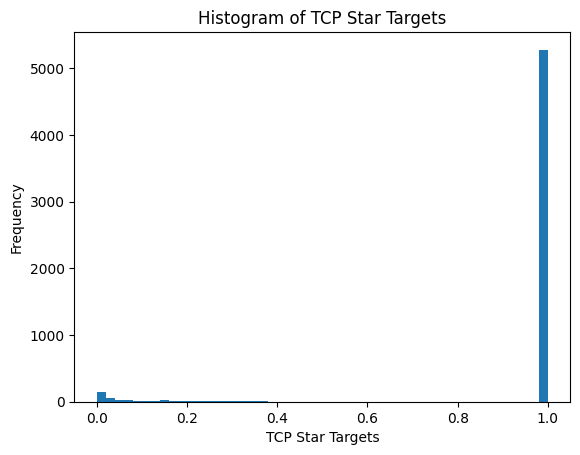

In [ ]:
#plot histogram of tcp_star_targets
import matplotlib.pyplot as plt
plt.hist(tcp_star_targets, bins=50)
plt.xlabel('TCP Star Targets')
plt.ylabel('Frequency')
plt.title('Histogram of TCP Star Targets')
plt.show()

In [ ]:
# Upsampling the errors to create a balanced batch 

# Select indices
correct_idx = np.where(y_hat == y_true_class)[0]
error_idx = np.where(y_hat != y_true_class)[0]

# You can duplicate errors to balance them
n_errors = len(error_idx)
n_correct = len(correct_idx)
upsample_errors = np.random.choice(error_idx, size=n_correct, replace=True)

balanced_idx = np.concatenate([correct_idx, upsample_errors])
np.random.shuffle(balanced_idx)

X_balanced = embeddings[balanced_idx]
y_balanced = tcp_star_targets[balanced_idx]
print("Balanced embeddings shape:", X_balanced.shape)
print("Balanced TCP Star Targets shape:", y_balanced.shape)

Balanced embeddings shape: (10552, 64)
Balanced TCP Star Targets shape: (10552,)


In [ ]:
n_correct

NameError: name 'n_correct' is not defined

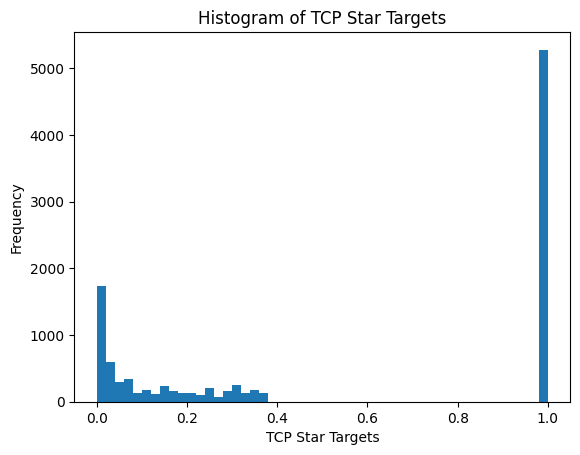

In [ ]:
#plot histogram of tcp_star_targets
import matplotlib.pyplot as plt
plt.hist(y_balanced, bins=50)
plt.xlabel('TCP Star Targets')
plt.ylabel('Frequency')
plt.title('Histogram of TCP Star Targets')
plt.show()

In [ ]:
tcp_targets= p_y_star / p_y_hat
print(tcp_targets.shape)

(5702,)


In [ ]:
X= X_balanced
y= y_balanced

In [ ]:
import torch.nn as nn

class ConfidenceNet(nn.Module):
    def __init__(self, input_dim):
        super(ConfidenceNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


In [ ]:
from sklearn.model_selection import train_test_split

# 80% for training, 20% for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
print(y_hat)
print(y_true_class)


[ 1 11  9 ... 11  9  1]
[ 8 11 11 ... 11  9  1]


In [ ]:
input_dim = X_train.shape[1]
num_bins = 40
bins = np.linspace(0, 1, num_bins + 1)
bin_ids = np.clip(np.digitize(y_train, bins) - 1, 0, num_bins - 1)


In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [ ]:
# LDS weights
def compute_lds_weights(y, num_bins=60, kernel_sigma=2.0):
    bins = np.linspace(0, 1, num_bins + 1)
    bin_ids = np.clip(np.digitize(y, bins) - 1, 0, num_bins - 1)
    counts = np.bincount(bin_ids, minlength=num_bins)

    distances = np.arange(num_bins)[:, None] - np.arange(num_bins)[None, :]
    kernel = np.exp(-0.5 * (distances / kernel_sigma) ** 2)
    kernel = kernel / kernel.sum(axis=1, keepdims=True)
    smoothed_counts = kernel @ counts

    weights = 1.0 / (smoothed_counts[bin_ids] + 1e-6)
    return (weights / weights.mean()).astype(np.float32)

lds_weights = compute_lds_weights(y_train, num_bins=num_bins, kernel_sigma=2.0)
lds_weights_tensor = torch.tensor(lds_weights, dtype=torch.float32)

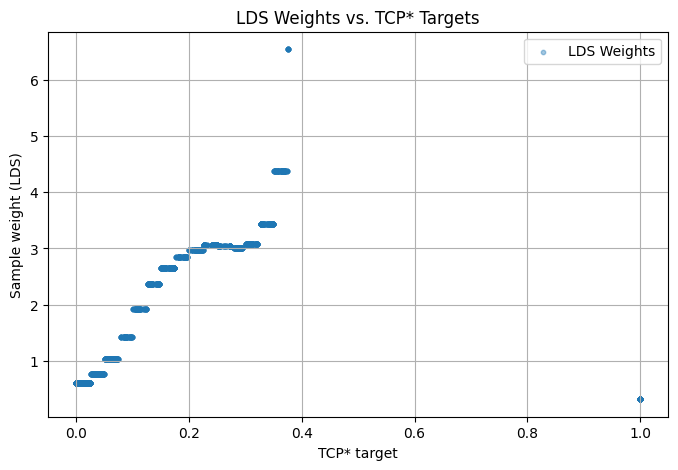

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(y_train, lds_weights, alpha=0.4, s=10, label="LDS Weights")
plt.title("LDS Weights vs. TCP* Targets")
plt.xlabel("TCP* target")
plt.ylabel("Sample weight (LDS)")
plt.grid(True)
plt.legend()
plt.show()

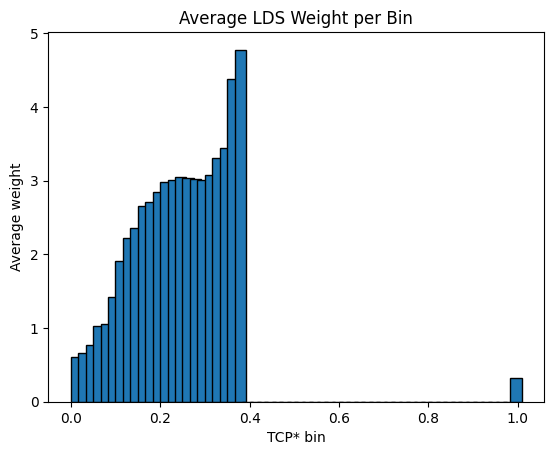

In [ ]:
import numpy as np

num_bins = 60
bins = np.linspace(0, 1, num_bins + 1)
bin_ids = np.digitize(y_train, bins) - 1
bin_ids = np.clip(bin_ids, 0, num_bins - 1)

bin_weights = [lds_weights[bin_ids == i].mean() if np.any(bin_ids == i) else 0 for i in range(num_bins)]

plt.bar(bins[:-1], bin_weights, width=0.025, align='edge', edgecolor='k')
plt.title("Average LDS Weight per Bin")
plt.xlabel("TCP* bin")
plt.ylabel("Average weight")
plt.show()

In [ ]:
# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, lds_weights_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)


In [ ]:
#FDS
def smooth_stats(mu, var, sigma=1.3):
    distances = torch.arange(num_bins).unsqueeze(1) - torch.arange(num_bins).unsqueeze(0)
    weights = torch.exp(-0.5 * (distances.float() / sigma) ** 2)
    weights /= weights.sum(dim=1, keepdim=True)
    mu_smooth = weights @ mu
    var_smooth = weights @ var
    return mu_smooth, var_smooth


In [ ]:

model = ConfidenceNet(input_dim)
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
criterion = nn.MSELoss()

In [ ]:
mu = torch.zeros(num_bins, input_dim)
var = torch.ones(num_bins, input_dim)

for epoch in range(60):
    model.train()
    train_losses = []

    # Step 1: Update bin-wise feature stats
    with torch.no_grad():
        for b in range(num_bins):
            idx = torch.tensor(bin_ids) == b
            if idx.sum() == 0: continue
            feats = X_train_tensor[idx]
            mu[b] = feats.mean(dim=0)
            var[b] = feats.var(dim=0)

    # Step 2: Apply FDS smoothing
    mu_smooth, var_smooth = smooth_stats(mu, var)

    # Step 3: Training loop
    for xb, yb, wb in train_loader:
        with torch.no_grad():
            yb_bin = torch.clamp(torch.bucketize(yb, torch.tensor(bins[1:-1])), 0, num_bins - 1)
            mean_b = mu_smooth[yb_bin]
            std_b = torch.sqrt(var_smooth[yb_bin] + 1e-6)
            xb_norm = (xb - mean_b) / std_b

        pred = model(xb_norm)
        loss = ((pred - yb) ** 2 * wb).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Step 4: Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_losses.append(loss.item())

    print(f"Epoch {epoch+1:02d} | Train Loss: {np.mean(train_losses):.6f} | Val Loss: {np.mean(val_losses):.6f}")

Epoch 01 | Train Loss: 0.020173 | Val Loss: 0.396208
Epoch 02 | Train Loss: 0.004125 | Val Loss: 0.398556
Epoch 03 | Train Loss: 0.002207 | Val Loss: 0.399608
Epoch 04 | Train Loss: 0.001339 | Val Loss: 0.399742
Epoch 05 | Train Loss: 0.001226 | Val Loss: 0.399743
Epoch 06 | Train Loss: 0.000779 | Val Loss: 0.399743
Epoch 07 | Train Loss: 0.000549 | Val Loss: 0.399772
Epoch 08 | Train Loss: 0.001949 | Val Loss: 0.399699
Epoch 09 | Train Loss: 0.002049 | Val Loss: 0.399609
Epoch 10 | Train Loss: 0.000906 | Val Loss: 0.399768
Epoch 11 | Train Loss: 0.000453 | Val Loss: 0.399774
Epoch 12 | Train Loss: 0.000408 | Val Loss: 0.399777
Epoch 13 | Train Loss: 0.001063 | Val Loss: 0.399735
Epoch 14 | Train Loss: 0.001750 | Val Loss: 0.392224
Epoch 15 | Train Loss: 0.001027 | Val Loss: 0.399706
Epoch 16 | Train Loss: 0.000412 | Val Loss: 0.399768
Epoch 17 | Train Loss: 0.000407 | Val Loss: 0.399770
Epoch 18 | Train Loss: 0.000569 | Val Loss: 0.399467
Epoch 19 | Train Loss: 0.000411 | Val Loss: 0.

In [ ]:
model.eval()
with torch.no_grad():
    X_test_tensor = torch.tensor(embeddings, dtype=torch.float32)
    confidence_scores = model(X_test_tensor).numpy()
print("Confidence scores shape:", confidence_scores)

Confidence scores shape: [0.99999976 1.         0.9999999  ... 1.         1.         1.        ]


In [ ]:
# print min max of confidence scores
print("Min confidence score:", np.min(confidence_scores))
print("Max confidence score:", np.max(confidence_scores))

Min confidence score: 0.9940498
Max confidence score: 1.0


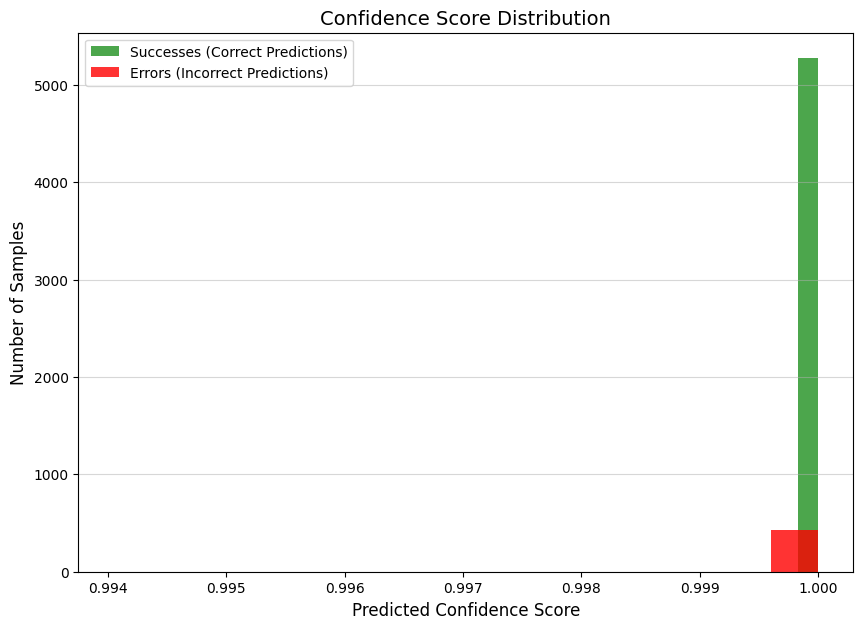

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_labels_int = label_encoder.fit_transform(y_labels)
is_correct = (y_hat == y_true_class)
success_confidences = confidence_scores[is_correct]
error_confidences = confidence_scores[~is_correct]

plt.figure(figsize=(10, 7))
plt.hist(success_confidences, bins=30, alpha=0.7, label='Successes (Correct Predictions)', color='green')
plt.hist(error_confidences, bins=15, alpha=0.8, label='Errors (Incorrect Predictions)', color='red')
plt.xlabel('Predicted Confidence Score', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Confidence Score Distribution', fontsize=14)
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()



In [ ]:
print(y_train.min(), y_train.max())

5.542017715419596e-06 1.0
